In [1]:
import os
os.chdir("..")

In [2]:
from src.local_validation.local_validation_model import LocalValidationModel
from omegaconf import OmegaConf
import seaborn as sns

from hydra.utils import instantiate
from omegaconf import DictConfig
import numpy as np

import pandas as pd

import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.loggers import TensorBoardLogger

from ptls.data_load.datasets import MemoryMapDataset
from ptls.data_load.iterable_processing import SeqLenFilter
from ptls.data_load import PaddedBatch
from ptls.frames.coles import ColesDataset
from ptls.frames import PtlsDataModule

from src.utils.logging_utils import get_logger
from src.preprocessing import preprocess
from tqdm.notebook import tqdm
from src.local_validation import LocalValidationModel

In [3]:
cfg_preprop = OmegaConf.load("config/preprocessing/churn.yaml")
cfg_validation = OmegaConf.load("config/validation/local_target_best_baseline.yaml")

In [4]:
train, val, test = preprocess(cfg_preprop)

# load pretrained sequence encoder
sequence_encoder = instantiate(cfg_validation["sequence_encoder"])
sequence_encoder.load_state_dict(torch.load(cfg_validation["path_to_state_dict"]))

data_train = MemoryMapDataset(train, [SeqLenFilter(cfg_validation["model"]["seq_len"])])
data_val = MemoryMapDataset(val, [SeqLenFilter(cfg_validation["model"]["seq_len"])])
data_test = MemoryMapDataset(test, [SeqLenFilter(cfg_validation["model"]["seq_len"])])

train_dataset: ColesDataset = instantiate(cfg_validation["dataset"], data=data_train)
val_dataset: ColesDataset = instantiate(cfg_validation["dataset"], data=data_val)
test_dataset: ColesDataset = instantiate(cfg_validation["dataset"], data=data_test)

datamodule: PtlsDataModule = instantiate(
    cfg_validation["datamodule"],
    train_data=train_dataset,
    valid_data=val_dataset,
    test_data=test_dataset,
)

[Memory]0.0s, 0.0min    : Loading _preprocess...
__________________________________________preprocess cache loaded - 4.5s, 0.1min


In [5]:
valid_model: LocalValidationModel = instantiate(
    cfg_validation["model"],
    backbone=sequence_encoder 
).to("cuda")

In [6]:
valid_model.load_state_dict(torch.load("saved_models/validation_head_0.pth"))

<All keys matched successfully>

In [7]:
trues = []
preds = []
with torch.no_grad():
    for x, y in tqdm(datamodule.train_dataloader()):
        x: PaddedBatch = x.to("cuda")
        res, mask =  valid_model(x.to("cuda"))
        target = x.payload["churn_target"][:, valid_model.seq_len - 1:]
        preds.append(res[mask].detach().cpu().numpy())
        trues.append(target[mask].detach().cpu().numpy())

preds_arr = np.concatenate(preds)
trues_arr = np.concatenate(trues)

  0%|          | 0/763 [00:00<?, ?it/s]

In [8]:
roc_auc_score(trues_arr, preds_arr)

0.5539699401089208

<Axes: ylabel='Count'>

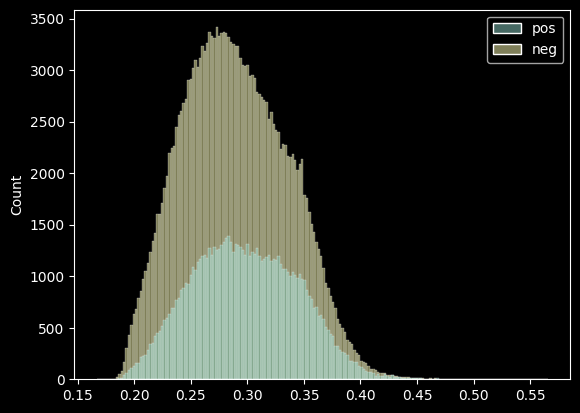

In [9]:
pos_scores = preds_arr[trues_arr.astype(bool)].flatten()
neg_scores = preds_arr[~trues_arr.astype(bool)].flatten()
sns.histplot({"pos": pos_scores, "neg": neg_scores}, color=["r", "g"])

In [67]:
f1_score(trues_arr, preds_arr > 0.3, average="macro")

0.5567172713150159

In [41]:
x.payload["amount"].shape

torch.Size([4, 202])

In [38]:
res.shape

torch.Size([4, 171, 1])

In [15]:
embs = valid_model.backbone(x)

In [16]:
embs.std()

tensor(0.2181, device='cuda:0')

In [17]:
preds_arr.std()

0.044681

In [46]:
torch.load("saved_models/validation_head_0.pth")

OrderedDict([('backbone.trx_encoder.embeddings.mcc_code.weight',
              tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
                      [-0.2284, -0.3753, -1.3562,  ...,  2.1706,  0.8651, -0.3460],
                      [-0.5555,  0.0176, -1.2588,  ...,  0.4013,  0.9811,  0.6363],
                      ...,
                      [-0.8384, -0.0414, -0.6208,  ..., -1.2112,  0.5985,  0.8309],
                      [-0.6471,  0.6951,  0.0348,  ..., -1.2419, -0.3373, -0.8759],
                      [ 0.3652,  0.3488,  0.1505,  ..., -0.3069, -2.3054,  0.4606]])),
             ('backbone.trx_encoder.numerical_batch_norm.bn.weight',
              tensor([1.2338])),
             ('backbone.trx_encoder.numerical_batch_norm.bn.bias',
              tensor([0.0132])),
             ('backbone.trx_encoder.numerical_batch_norm.bn.running_mean',
              tensor([4.3523])),
             ('backbone.trx_encoder.numerical_batch_norm.bn.running_var',
              ten

In [50]:
x.payload["churn_target"]

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 